In [1]:

import time
import dataframe_image as dfi
import numpy as np
import pandas as pd
import xgboost
import os
import shap
import csv

from fpdf import FPDF
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.inspection import PartialDependenceDisplay as PDP
from sklearn.inspection import partial_dependence as pdep
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
%load_ext autoreload
%autoreload 2
import market_models.src.features.build_features as build_features

xgboost.set_config(verbosity = 0)


In [2]:
def prepareDir(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)
    for file in os.listdir(dir):
        os.remove(dir + file)

In [3]:
####### PATHS

INPUT = '../data/processed/'
INTERMEDIATE = '../reports/'
OUTPUT = '..data/processed/'

DATA_NAME = 'netrisk_casco_2023_11_14__2023_11_20'

DATA_PATH = f'{INPUT}{DATA_NAME}_processed.csv'
FEATURES_PATH = f'{INPUT}{DATA_NAME}_features.txt'
CATEGORIES_PATH = f'{INPUT}external/'
KPI_DATA_PATH = f'{INTERMEDIATE}{DATA_NAME}_pdf_data/'
PDF_PATH = OUTPUT + DATA_PATH.split('/')[2].replace('.xlsx', '') + '_'


####### CONSTANTS

TEST_SIZE = 0.1
RANDOM_STATE = 42
BONUS_MALUS_CLASSES = ['B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2', 'B1', 'A0', 'M1', 'M2', 'M3', 'M4']
KPI_TABLE_COLUMNS = ['MAE', 'sd MAE', 'RMSE', 'sd RMSE', 'MAPE', 'sd MAPE', 'Avg target']

TARGET_VARIABLE = 'ALFA_price'
PRED_TARGET_VARIABLE = f'predicted_{TARGET_VARIABLE}'
CATEGORIES_PATH = f'{CATEGORIES_PATH}{TARGET_VARIABLE}'

PARAMS_GRID = {
    'objective': ['reg:squarederror'],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 6, 7, 8, 9, 10],
    'enable_categorical': [False, True],
    'eval_metric': ['mae'],
    'n_estimators': [200, 400, 600, 800, 1000, 1200],
    'eta': [0.05, 0.1, 0.15]
}


prepareDir(KPI_DATA_PATH)

In [4]:
data = pd.read_csv(DATA_PATH)

In [5]:
data

,Unnamed: 0,id_case,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,...,GENERALI_price,GENERTEL_price,GROUPAMA_price,K&AMP;H_price,KÖBE_price,MAGYAR_price,SIGNAL_price,UNION_price,UNIQA_price,WÁBERER_price
0,0,0,2023_11_14,True,KIA,2,998,49,899,15337.400,...,126131.0,NaN,102780.0,199264.0,100650.0,NaN,NaN,82175.0,115246.0,167196.0
1,1,1,2023_11_14,True,FORD,1,999,92,1280,24388.000,...,270092.0,NaN,142080.0,344622.0,116754.0,137964.0,NaN,146810.0,203799.0,NaN
2,2,2,2023_11_14,True,DACIA,2,999,54,974,6757.400,...,229026.0,NaN,109356.0,163430.0,129564.0,100000.0,NaN,155078.0,150166.0,NaN
3,3,3,2023_11_14,True,HYUNDAI,2,998,49,996,8447.400,...,154209.0,NaN,178620.0,162550.0,100284.0,100000.0,NaN,81991.0,141611.0,NaN
4,4,4,2023_11_14,True,SKODA,2,999,59,1270,11568.336,...,228020.0,NaN,134844.0,220854.0,120414.0,NaN,NaN,139700.0,162120.0,206956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,2056,2056,2023_11_20,True,TOYOTA,5,998,51,915,7007.000,...,102904.0,NaN,NaN,74754.0,69540.0,100000.0,114591.0,79529.0,88219.0,48900.0
2057,2057,2057,2023_11_20,True,BMW,7,1499,80,1300,14339.000,...,249943.0,NaN,208704.0,303093.0,176778.0,NaN,395303.0,192164.0,142579.0,NaN
2058,2058,2058,2023_11_20,True,HONDA,3,1318,75,1073,11619.400,...,122076.0,NaN,158736.0,160826.0,69540.0,100000.0,200891.0,117601.0,131381.0,NaN
2059,2059,2059,2023_11_20,True,SEAT,4,999,59,1100,11545.222,...,69789.0,NaN,105864.0,85562.0,76494.0,100000.0,133417.0,119768.0,86466.0,NaN


In [6]:
data = pd.read_csv(DATA_PATH)
with open(FEATURES_PATH) as file:
    features = file.readlines()
    features = [feature.replace('\n', '') for feature in features]
    feature_dtypes = {feature.split(',')[0] : feature.split(',')[1] for feature in features}
    features = [feature.split(',')[0] for feature in features]

for feature in features:
    print(feature, feature_dtypes[feature].replace('object', 'category'))
    data[feature] = data[feature].astype(feature_dtypes[feature])
    if data[feature].dtype == 'category' and feature == 'BonusMalus':
        ordinal_encoder = OrdinalEncoder(categories = [BONUS_MALUS_CLASSES])
        data[feature] = ordinal_encoder.fit_transform(data[[feature]])
    elif data[feature].dtype == 'category':
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])

isRecent bool
CarMake category
CarAge int64
ccm int64
kw int64
kg int64
car_value float64
CarMakerCategory float64
PostalCode int64
PostalCode2 int64
PostalCode3 int64
Category int64
Longitude float64
Latitude float64
Age int64
LicenseAge int64
BonusMalus category
BonusMalusCode int64


In [7]:
data

,Unnamed: 0,id_case,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,...,GENERALI_price,GENERTEL_price,GROUPAMA_price,K&AMP;H_price,KÖBE_price,MAGYAR_price,SIGNAL_price,UNION_price,UNIQA_price,WÁBERER_price
0,0,0,2023_11_14,True,10,2,998,49,899,15337.400,...,126131.0,NaN,102780.0,199264.0,100650.0,NaN,NaN,82175.0,115246.0,167196.0
1,1,1,2023_11_14,True,7,1,999,92,1280,24388.000,...,270092.0,NaN,142080.0,344622.0,116754.0,137964.0,NaN,146810.0,203799.0,NaN
2,2,2,2023_11_14,True,5,2,999,54,974,6757.400,...,229026.0,NaN,109356.0,163430.0,129564.0,100000.0,NaN,155078.0,150166.0,NaN
3,3,3,2023_11_14,True,9,2,998,49,996,8447.400,...,154209.0,NaN,178620.0,162550.0,100284.0,100000.0,NaN,81991.0,141611.0,NaN
4,4,4,2023_11_14,True,20,2,999,59,1270,11568.336,...,228020.0,NaN,134844.0,220854.0,120414.0,NaN,NaN,139700.0,162120.0,206956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,2056,2056,2023_11_20,True,22,5,998,51,915,7007.000,...,102904.0,NaN,NaN,74754.0,69540.0,100000.0,114591.0,79529.0,88219.0,48900.0
2057,2057,2057,2023_11_20,True,2,7,1499,80,1300,14339.000,...,249943.0,NaN,208704.0,303093.0,176778.0,NaN,395303.0,192164.0,142579.0,NaN
2058,2058,2058,2023_11_20,True,8,3,1318,75,1073,11619.400,...,122076.0,NaN,158736.0,160826.0,69540.0,100000.0,200891.0,117601.0,131381.0,NaN
2059,2059,2059,2023_11_20,True,19,4,999,59,1100,11545.222,...,69789.0,NaN,105864.0,85562.0,76494.0,100000.0,133417.0,119768.0,86466.0,NaN


In [8]:
# Make last column name a variable to generelize
data = data[features + [TARGET_VARIABLE]]
data = data.dropna()

In [9]:
features

['isRecent',
 'CarMake',
 'CarAge',
 'ccm',
 'kw',
 'kg',
 'car_value',
 'CarMakerCategory',
 'PostalCode',
 'PostalCode2',
 'PostalCode3',
 'Category',
 'Longitude',
 'Latitude',
 'Age',
 'LicenseAge',
 'BonusMalus',
 'BonusMalusCode']

In [10]:
data.dtypes

isRecent               bool
CarMake               int64
CarAge                int64
ccm                   int64
kw                    int64
kg                    int64
car_value           float64
CarMakerCategory    float64
PostalCode            int64
PostalCode2           int64
PostalCode3           int64
Category              int64
Longitude           float64
Latitude            float64
Age                   int64
LicenseAge            int64
BonusMalus          float64
BonusMalusCode        int64
ALFA_price          float64
dtype: object

In [11]:
data[features]

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode
0,True,10,2,998,49,899,15337.400,1.00,1016,10,101,2,19.0404,47.4984,39,18,1.0,2
1,True,7,1,999,92,1280,24388.000,1.00,1016,10,101,2,19.0404,47.4984,48,18,0.0,1
2,True,5,2,999,54,974,6757.400,0.97,1016,10,101,2,19.0404,47.4984,26,18,0.0,1
3,True,9,2,998,49,996,8447.400,0.97,1016,10,101,2,19.0404,47.4984,56,18,7.0,8
4,True,20,2,999,59,1270,11568.336,1.00,1016,10,101,2,19.0404,47.4984,42,18,7.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,True,22,5,998,51,915,7007.000,0.97,3754,37,375,7,20.7500,48.4500,48,18,0.0,1
2057,True,2,7,1499,80,1300,14339.000,1.00,2363,23,236,2,19.2370,47.3433,24,18,0.0,1
2058,True,8,3,1318,75,1073,11619.400,1.00,3646,36,364,7,20.4333,48.1667,36,18,0.0,1
2059,True,19,4,999,59,1100,11545.222,1.00,6724,67,672,7,20.1482,46.2530,43,18,0.0,1


In [12]:
# Make data overview

describe = pd.concat([data.describe(), pd.DataFrame(np.array([len(data[col].unique()) for col in data.columns]).reshape(1, -1), index = ['unique'], columns = data.columns)])
describeStyle = describe.T.style.format(precision = 2)
dfi.export(describeStyle, KPI_DATA_PATH + 'dataOverview.png', dpi = 200)

In [17]:
# Various model related methods

def modelFit(trData, n_estimators = 1200, max_depth = 8):
    model = xgboost.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth, eta=0.1, gamma = 5, subsample=1, colsample_bytree=0.8, min_child_weight = 1 , eval_metric = 'mae', enable_categorical = True)
    model.fit(transposed_train[features], transposed_train[ TARGET_VARIABLE])
    return model

def makeDMatrix(features, target):
    return xgboost.DMatrix(features, target, enable_categorical = True)

def modelTrain(trData, teData, param = None):
    dtrain = xgboost.DMatrix(trData[features], trData[TARGET_VARIABLE], enable_categorical = True)
    dtest = xgboost.DMatrix(teData[features], teData[TARGET_VARIABLE], enable_categorical = True)
    if param is None:
        param = {'n_estimators' : 1200, 'max_depth' : 6, 'eta' : 0.05, 'eval_metric' : 'mae' }
    evallist  = [(dtest,'eval'), (dtrain,'train')]
    num_round = 800
    return xgboost.train( param, dtrain, num_round, evals = evallist, verbose_eval = False)

def modelCV(data, param = None):
    dtrain = xgboost.DMatrix(data[features], data[TARGET_VARIABLE], enable_categorical = True)
    if param is None:
        param = {'n_estimators' : 1200, 'max_depth' : 6, 'eta' : 0.05, 'eval_metric' : 'mae' }
    num_round = 400
    return xgboost.cv( param, dtrain, num_round, nfold=3, verbose_eval = False, as_pandas= True)

def mergePredictions(model):
    output = transposed_test.copy()
    try:
        output[ PRED_TARGET_VARIABLE] = model.predict(transposed_test[features])
    except Exception as e:
        dtest = xgboost.DMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE], enable_categorical = True)
        output[ PRED_TARGET_VARIABLE] = model.predict(dtest)
    output['error'] = output[TARGET_VARIABLE] - output[ PRED_TARGET_VARIABLE]
    output['percentageError'] = output['error'] / output[TARGET_VARIABLE] * 100
    return output

def plotHistErrorPercenage(preds):
    plt.hist(preds.percentageError, range = [-100, 100], bins = 40, weights = np.ones(len(preds.percentageError)) / len(preds.percentageError))
    plt.xlabel('Error percentage')
    plt.ylabel('Percent of errors')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.savefig(KPI_DATA_PATH + 'ErrorDistribution.jpg')
    plt.show()

def plotFeatureDistribution(data, feature):
    plt.figure(figsize = (10, 10))
    if feature in feature_dtypes.keys() and feature_dtypes[feature] == 'bool':
        data[feature].value_counts().plot(kind = 'bar', title = feature)
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches = 'tight')
    else:
        plt.hist(data[feature], bins = 40, weights = np.ones(len(data[feature])) / len(data[feature]), alpha=0.5)
        plt.xlabel(feature)
        plt.ylabel('Percent of values')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.savefig(KPI_DATA_PATH + feature + 'Distribution.jpg', bbox_inches = 'tight')
    plt.close()



In [18]:
makeDMatrix(data[features], data[TARGET_VARIABLE])

In [19]:
def kFoldCrossValidation(k = 5, param = None, debug = True):
    kf = KFold(n_splits=k)
    maes = []
    mses = []
    mapes = []
    fold_num = 0
    for transposed_train, transposed_test in kf.split(data):
        fold_num += 1
        transposed_train, transposed_test = data.iloc[transposed_train], data.iloc[transposed_test]
        trainModel = modelTrain(transposed_train, transposed_test, param = param)
        dmat = makeDMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE])
        mae = mean_absolute_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        mse = mean_squared_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        mape = mean_absolute_percentage_error(transposed_test[TARGET_VARIABLE].values, trainModel.predict(dmat))
        if debug:
            print(f"Summary for fold {fold_num}")
            print("Mean absolute error is {}, which is {}% of mean {}.".format(round(mae, 3), round(mae / data[TARGET_VARIABLE].mean() * 100, 3), TARGET_VARIABLE))
            print("Mean square error is {}.".format(round(mse, 3)))
            print("Mean absolute percentage error is {}%.".format(round(mape * 100, 3)))
            print("-------------------------------------------------------------")
        maes.append(mae)
        mses.append(mse)
        mapes.append(mape)
        
    mMae, sMae = np.mean(maes), np.std(maes)
    mRMse, sRMse = np.mean(np.sqrt(mses)), np.std(np.sqrt(mses))
    mMape, sMape = np.mean(mapes), np.std(mapes)
    meanPrice = data[TARGET_VARIABLE].mean()
    
    rmMae, rsMae = round(mMae, 2), round(sMae / mMae * 100, 3)
    rmRMse, rsRMse = round(mRMse, 2), round(sRMse / mRMse * 100, 2)
    rmMape, rsMape = round(mMape * 100, 2), round(sMape / mMape, 3)
    
    if debug:
        print(f"Mean MAE over {k} fold Cross-validation is {rmMae} ± {rsMae}%, which is {round(mMae / meanPrice * 100, 3)} ± {round(sMae / meanPrice * 100, 3)}% percent of mean {TARGET_VARIABLE}.")
        print(f"Mean RMSE over {k} fold Cross-validation is {rmRMse} ± {rsRMse}%.")
        print(f"Mean MAPE over {k} fold Cross-validation is {rmMape} ± {rsMape}%.")
        
    return rmMae, rmRMse, rmMape

In [20]:
params = {'n_estimators' : 1200, 'max_depth' : 6, 'eta' : 0.05, 'eval_metric' : 'mae' }

hyperparameter_ranges = {
    'learning_rate': np.arange(0.01, 0.31, 0.01),
    'n_estimators': np.arange(100, 1100, 100),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': np.arange(0.5, 1.01, 0.1),
    'colsample_bytree': np.arange(0.5, 1.01, 0.1),
    'gamma': np.arange(0, 0.21, 0.01),
    'lambda': np.arange(0, 1.1, 0.1),
}

def hyperparameter_tuning(params, plot_search = False):
    best_hyperparameters = {}  # To store the best hyperparameter value for each parameter
    min_mae_values = {}  # To store the corresponding minimum MAE values
    
    for hp, hp_values in hyperparameter_ranges.items():
        maes = []
        print(f"Iterating over {hp} values...")
        
        # Initialize the minimum MAE and corresponding hyperparameter value
        min_mae = float('inf')
        best_value = None
        current_params = params
        for value in hp_values:
            current_params[hp] = value
            mae, mse, mape = kFoldCrossValidation(k=3, param=current_params, debug=False)
            maes.append(mae)
            
            # Check if the current value gives a lower MAE
            if mae < min_mae:
                min_mae = mae
                best_value = value
        
        # Store the best hyperparameter value in the dictionary
        best_hyperparameters[hp] = best_value
        min_mae_values[hp] = min_mae
        
        if plot_search:
        # Plot the results
            plt.title(f'Search for optimal {hp} value:')
            plt.plot(hp_values, maes)
            plt.xlabel(f'{hp}')
            plt.ylabel('Mean Absolute Error (MAE)')
            plt.show()

    # Display the best hyperparameter values
    print("\nBest Hyperparameter Values:")
    for hp, value in best_hyperparameters.items():
        print(f"{hp}: {value}")
    
    mae, mse, mape = kFoldCrossValidation(k=3, param=best_hyperparameters)
    
    return best_hyperparameters, mae

Iterating over learning_rate values...


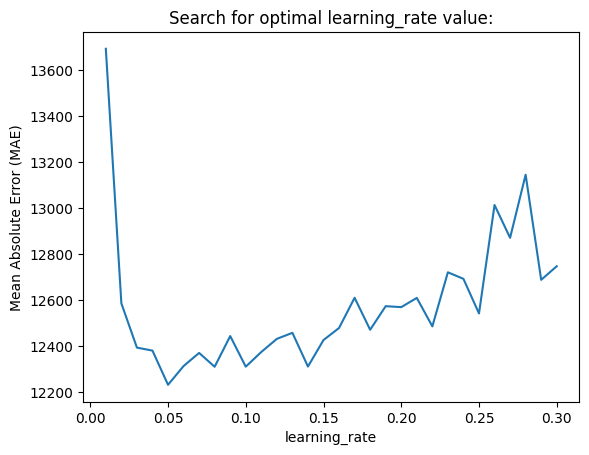

Iterating over n_estimators values...


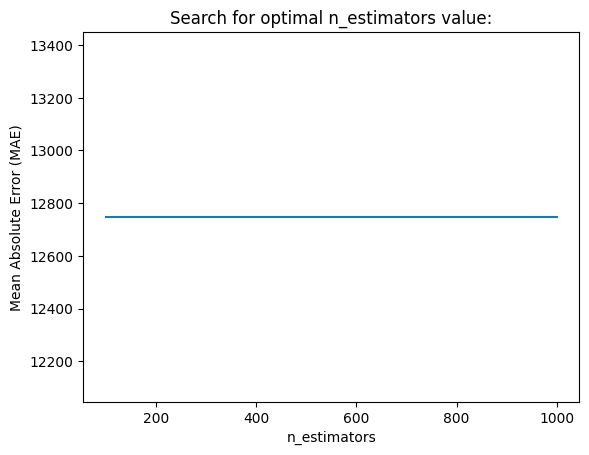

Iterating over max_depth values...


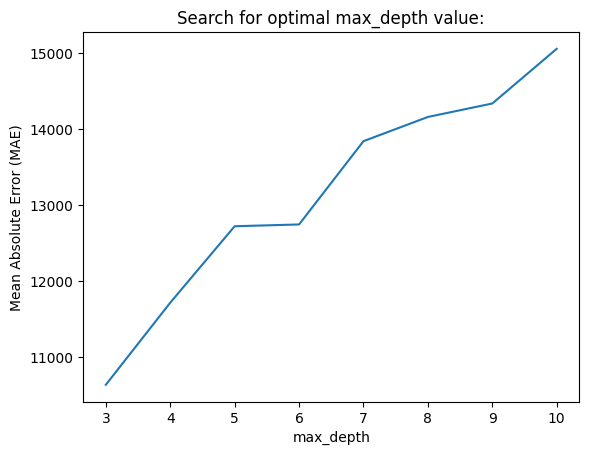

Iterating over min_child_weight values...


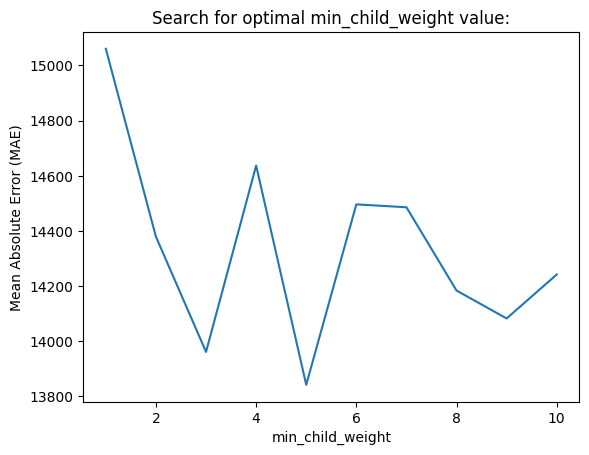

Iterating over subsample values...


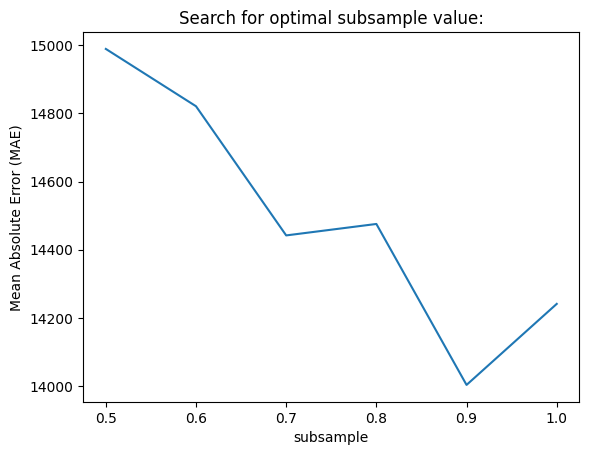

Iterating over colsample_bytree values...


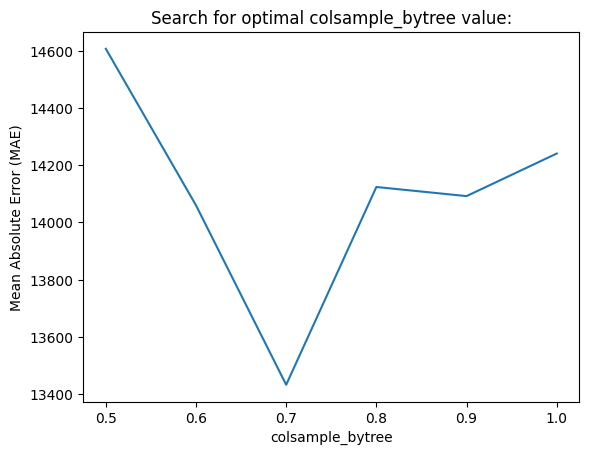

Iterating over gamma values...


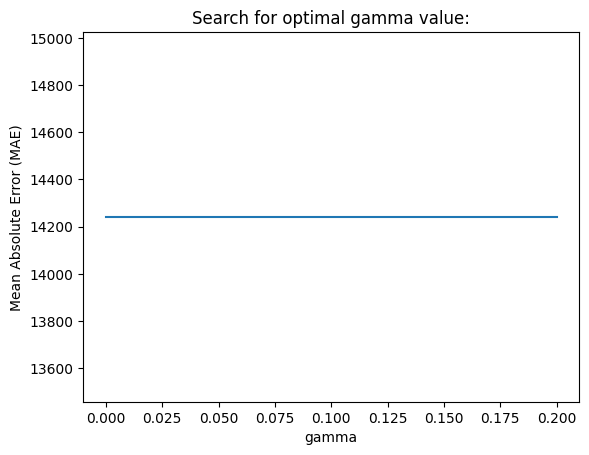

Iterating over lambda values...


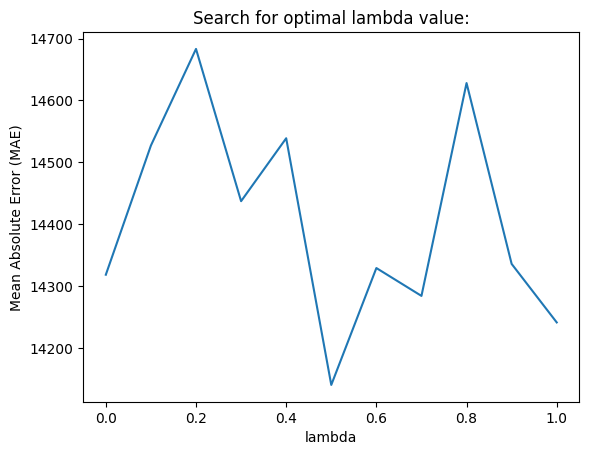


Best Hyperparameter Values:
learning_rate: 0.05
n_estimators: 100
max_depth: 3
min_child_weight: 5
subsample: 0.8999999999999999
colsample_bytree: 0.7
gamma: 0.0
lambda: 0.5
Summary for fold 1
Mean absolute error is 13312.568, which is 9.891% of mean ALFA_price.
Mean square error is 890086191.085.
Mean absolute percentage error is 6.884%.
-------------------------------------------------------------
Summary for fold 2
Mean absolute error is 9022.901, which is 6.704% of mean ALFA_price.
Mean square error is 236990968.973.
Mean absolute percentage error is 6.802%.
-------------------------------------------------------------
Summary for fold 3
Mean absolute error is 9193.105, which is 6.83% of mean ALFA_price.
Mean square error is 283392943.059.
Mean absolute percentage error is 6.768%.
-------------------------------------------------------------
Mean MAE over 3 fold Cross-validation is 10509.52 ± 18.871%, which is 7.808 ± 1.473% percent of mean ALFA_price.
Mean RMSE over 3 fold Cross-

In [21]:
maes = []
params = {'n_estimators' : 1200, 'max_depth' : 6, 'eta' : 0.05, 'eval_metric' : 'mae' }
best_hyperparameters, mae = hyperparameter_tuning(params)    

In [153]:
modelCV(data, best_hyperparameters)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,75311.682067,2406.968032,76074.702246,5264.164726
1,68334.915832,2213.045466,69690.748232,4513.989097
2,62701.193170,2209.340625,64581.290082,3877.954899
3,57807.901156,1820.742602,60443.918444,3738.887099
4,53670.054829,1667.410369,56859.876467,3675.940438
...,...,...,...,...
395,5432.591997,103.701009,19622.489713,1903.330895
396,5426.630482,105.447017,19621.417658,1904.539792
397,5421.922968,106.549338,19618.517731,1905.830629
398,5417.085882,105.097979,19612.153083,1911.153120


In [72]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'features' is a list of feature column names
# 'TARGET_VARIABLE' is the target variable name

# Extract features and target variable
X = data[features].values
y = data[TARGET_VARIABLE].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model using TensorFlow and Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Assuming a regression task, so no activation for the output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test_scaled, y_test)
print(f"Mean Squared Error on Test Set: {loss}")


Epoch 1/50
50/50 [==============================] - 1s 2ms/step - loss: 134564.4062 - val_loss: 134614.8906
Epoch 2/50
50/50 [==============================] - 0s 1ms/step - loss: 134277.3906 - val_loss: 133836.8281
Epoch 3/50
50/50 [==============================] - 0s 1ms/step - loss: 132298.0156 - val_loss: 129812.2578
Epoch 4/50
50/50 [==============================] - 0s 985us/step - loss: 124773.5625 - val_loss: 117036.4922
Epoch 5/50
50/50 [==============================] - 0s 1ms/step - loss: 104692.9219 - val_loss: 88818.7578
Epoch 6/50
50/50 [==============================] - 0s 1ms/step - loss: 73768.5391 - val_loss: 61130.3555
Epoch 7/50
50/50 [==============================] - 0s 1ms/step - loss: 48802.9141 - val_loss: 42174.7500
Epoch 8/50
50/50 [==============================] - 0s 1ms/step - loss: 36071.2812 - val_loss: 35561.2266
Epoch 9/50
50/50 [==============================] - 0s 960us/step - loss: 32511.3730 - val_loss: 33727.0547
Epoch 10/50
50/50 [==============

In [98]:
np.mean(np.abs(model.predict(X_test_scaled).ravel() - y_test))

13/13 [==============================] - 0s 656us/step


28036.049770336056

In [99]:
np.mean(np.abs(model.predict(X_test_scaled).ravel() - y_test))

13/13 [==============================] - 0s 620us/step


28036.049770336056

In [100]:
loss / len(y_test)

70.44233864635679

In [16]:
kpi_data = [[rmMae, rsMae, rmRMse, rsRMse, rmMape, rsMape, round(data[TARGET_VARIABLE].mean(), 1)]]
kpi = pd.DataFrame(data = kpi_data, columns = KPI_TABLE_COLUMNS).astype('str')

In [17]:
for col in data.columns:
    plotFeatureDistribution(data, col)

In [134]:
transposed_train, transposed_test = train_test_split(data, test_size = 0.2, random_state = 42)
model = modelTrain(transposed_train, transposed_test, param = best_hyperparameters)

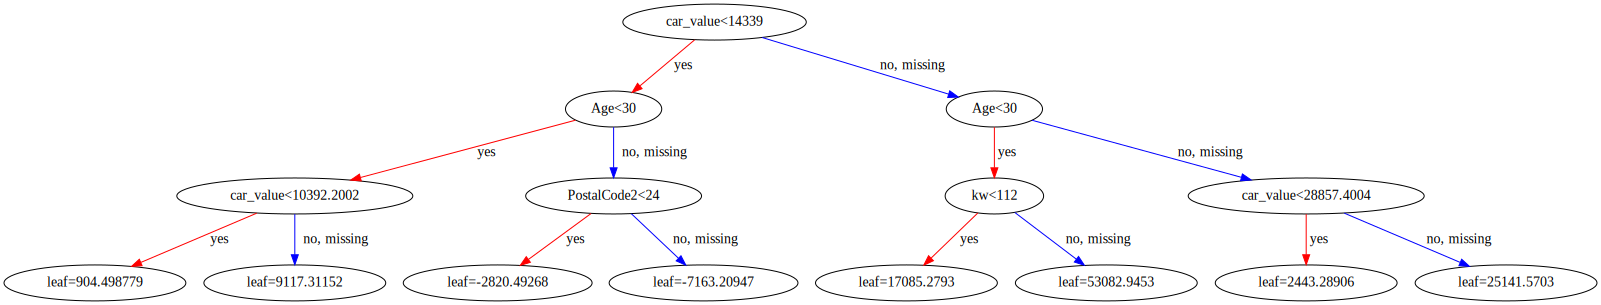

In [136]:
xgboost.to_graphviz(model, num_trees=1)

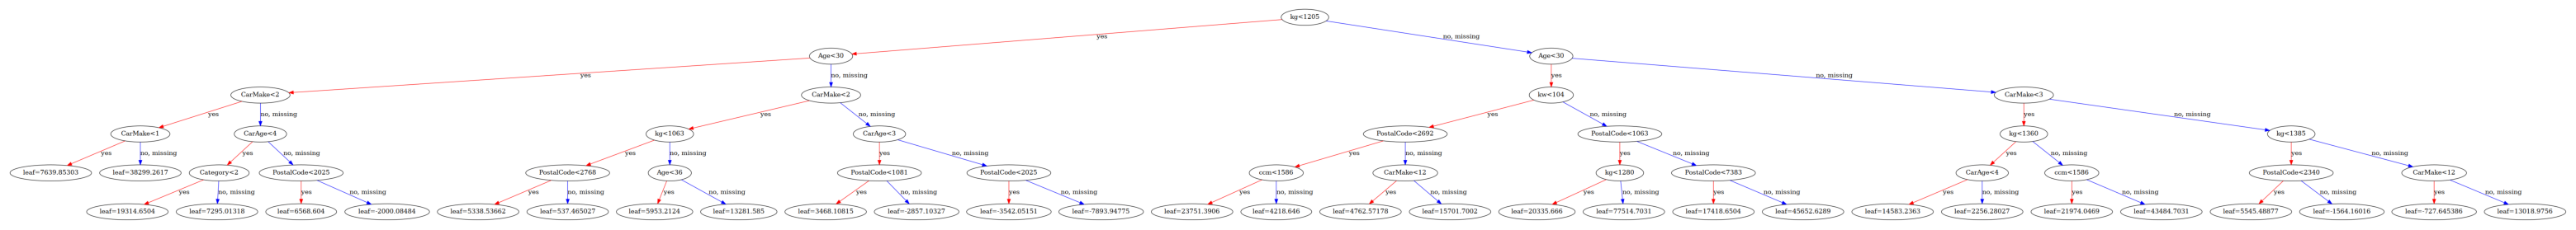

In [105]:
xgboost.plot_tree(model, num_trees=2, rankdir='TB', ax = plt.figure(figsize = (40, 40)).add_subplot(111))
plt.savefig('xgboost_tree.png')

# Show the plot (optional)
#plt.show()

In [105]:
scModel = xgboost.XGBRegressor(n_estimators = 1200, max_depth = 6)
scModel.fit(transposed_train[features].select_dtypes(include='number'), transposed_train[TARGET_VARIABLE])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [106]:
explainer = shap.Explainer(scModel)
shap_values = explainer.shap_values(transposed_test[features].values[ : 1000])

shap.summary_plot(shap_values, transposed_test[features].iloc[ : 1000], feature_names = features)

ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/shap/shap/issues/580.

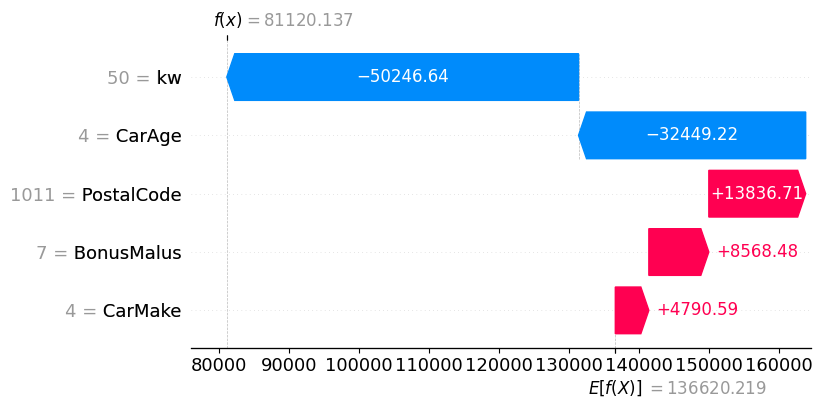

In [56]:
id = 21
plt.figure(figsize=(20, 20))
shap.waterfall_plot(shap.Explanation(values=shap_values[id],
                                     base_values=explainer.expected_value,
                                     data=transposed_test.iloc[id],
                                     feature_names=features),
                    max_display=8)  # Adjust max_display as needed

plt.show()

In [57]:
data.

BonusMalus         0.0
CarAge             3.0
kw                53.0
PostalCode      1036.0
CarMake           22.0
ALFA_price    190860.0
Name: 21, dtype: float64

In [95]:
def pdpSingle(feature):
    return PDP.from_estimator(scModel, transposed_train[features].select_dtypes(include = 'number'), [feature], kind='both', ice_lines_kw = {"color" : "black"}, centered = True, pd_line_kw = {"color" : "red", "lw" : 3, "linestyle" : "--"})

for col in transposed_train[features].select_dtypes(include = 'number').columns:
    pdpSingle(col).figure_.savefig(KPI_DATA_PATH + 'PDPandICE' + col + 'Plot.jpg')
    plt.close()

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


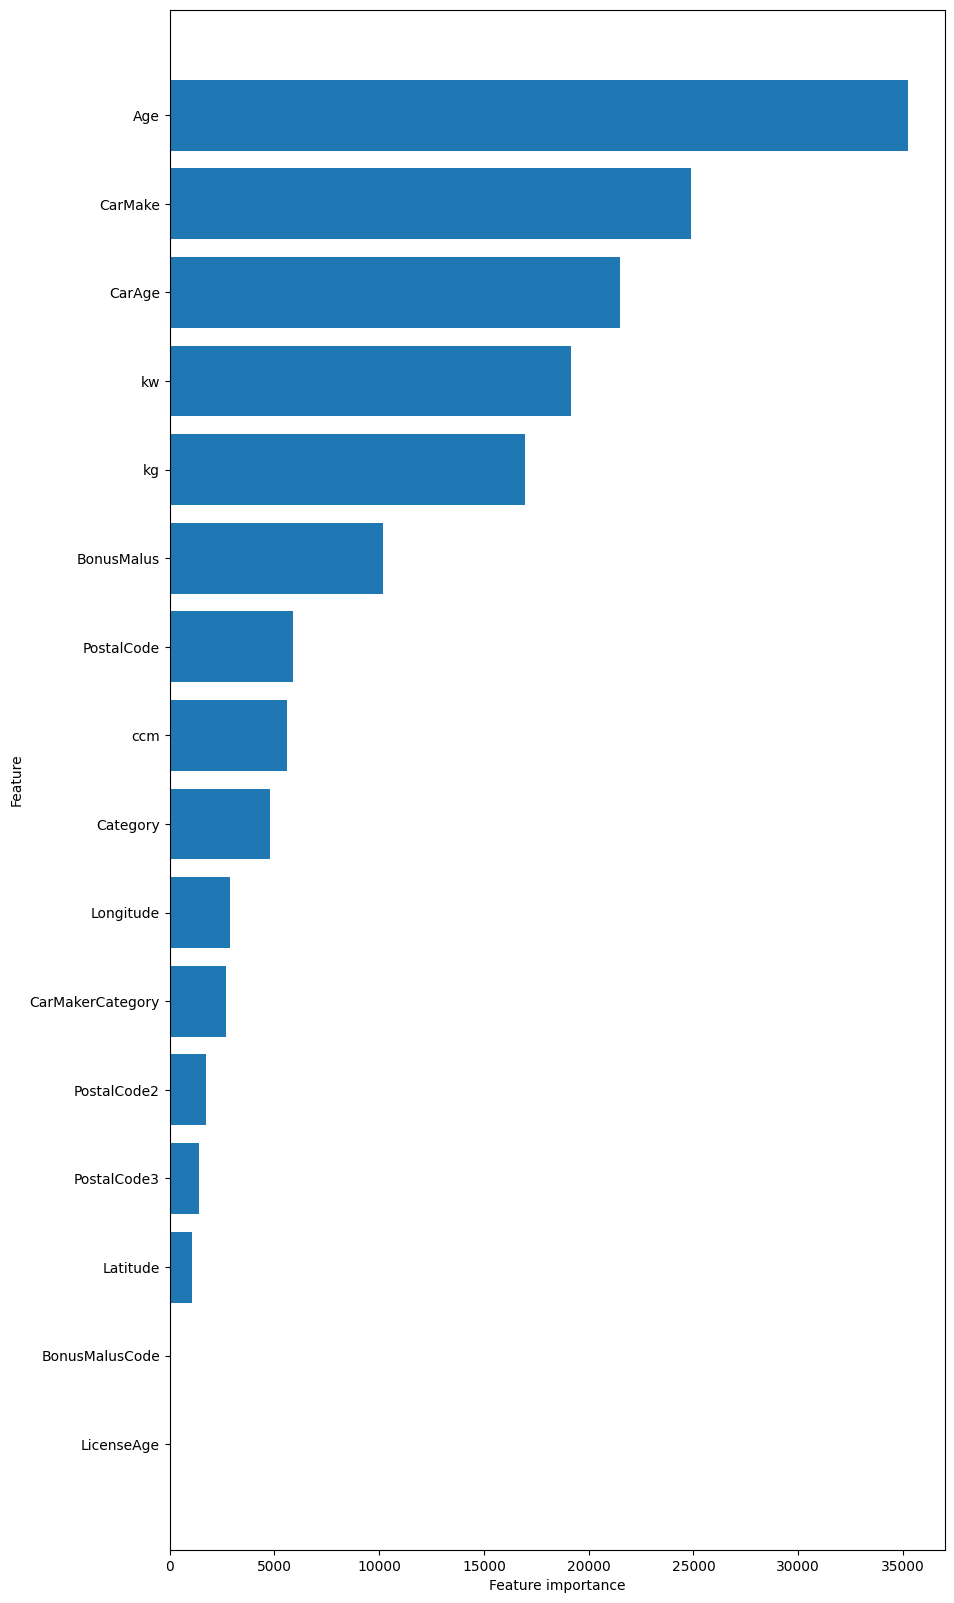

In [112]:
partialDepenadanceFeatureImportance = []
for col in transposed_train[features].select_dtypes(include = 'number').columns:
    partialDepenadanceFeatureImportance.append(np.std(pdep(scModel, transposed_train[features].select_dtypes(include = 'number'), [col])['average']))

cols = transposed_train[features].select_dtypes(include = 'number').columns
ind = [x for _, x in sorted(zip(partialDepenadanceFeatureImportance, cols))]
plt.figure(figsize = (10, 20))
plt.barh(y = ind, width = sorted(partialDepenadanceFeatureImportance))
plt.ylabel('Feature')
plt.xlabel('Feature importance')
plt.savefig(KPI_DATA_PATH + 'PDPimportancePlot.jpg', bbox_inches = 'tight')

In [50]:
def getQauntSplit(step = 50):
    return [i / 1000 for i in range(0, 1001, step)]

quant = getQauntSplit(int(np.ceil(100000 / len(transposed_train))))
qr = transposed_test[TARGET_VARIABLE].quantile(quant)
qp = pd.Series(model.predict(makeDMatrix(transposed_test[features], transposed_test[TARGET_VARIABLE]))).quantile(quant)

plt.scatter(qr, qp, alpha = 0.8, s = 40)
x = np.linspace(qr.min(),  qr.max())
plt.plot(x, x, c = 'r')
plt.xlabel('Real quantiles for training data')
plt.ylabel('Predicted quantiles for training data')
plt.savefig(KPI_DATA_PATH + 'QQplot.jpg', bbox_inches = 'tight')
plt.close()

In [52]:
def quantPlot(out, feature, numQuant = 20):
    type = True # Does the feature have more than 20 unique values in train data, 20 because it looks bad with more
    fQuant = None
    cats = None
    if len(out[feature].unique()) > 30 and feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object':
        return
    if len(out[feature].unique()) < numQuant or (feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object'):
        out['QuantCat'] = out[feature]
        type = False
    else:
        fQuant = out[feature].quantile(getQauntSplit(1000 // numQuant)).values
        cats = list(pd.Series(fQuant).unique())
        def getQId(x):
            for i in range(0, len(cats) - 1):
                if x >= cats[i] and x <= cats[i + 1]:
                    return i
            return len(cats) - 1
        out['QuantCat'] = out[feature].apply(lambda x: getQId(x))
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]


    agg_age = out.groupby('QuantCat')

    fig, ax = plt.subplots(figsize = (14, 14))
    if type:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker = 'o', color = 'b', alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[ PRED_TARGET_VARIABLE].mean().dropna(), marker = 'o', color = 'r', alpha=0.6)
        ax.set_xticks(sorted(list(out['QuantCat'].unique())))
    else:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker = 'o', color = 'b', alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[ PRED_TARGET_VARIABLE].mean().dropna(), marker = 'o', color = 'r', alpha=0.6)
        if feature == 'CarMaker':
            ax.set_xticklabels(sorted([str(x)[:4] for x in list(out['QuantCat'].unique())]))
        else:
            ax.set_xticklabels(sorted(list(out['QuantCat'].unique())))




    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real', 'Predicted'])
    plt.savefig(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', bbox_inches = 'tight')
    plt.close()
    ret =  pd.DataFrame(agg_age[TARGET_VARIABLE].mean() - agg_age[ PRED_TARGET_VARIABLE].mean())
    #print(ret)
    if type:
        #print(cats, out['QuantCat'].unique())
        ret.index = [cats[i] for i in range(len(cats)) if i in out['QuantCat'].unique()]

    return ret

out = mergePredictions(model)
agg_errors = {}
for col in transposed_test.columns:
    agg_errors[col] = quantPlot(out, col)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


In [53]:
# Function to compare two models based on quantile mean aggregated by a feature

def quantPlots(outs, feature, numQuant = 20):
    type = True
    fQuant = None
    featureCol = outs[0][feature]
    if len(featureCol.unique()) < numQuant:
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = featureCol
        type = False
    else :
        fQuant = featureCol.quantile(getQauntSplit(1000 // numQuant)).values
        print(fQuant)
        def getQId(x):
            id = 0
            while id < len(fQuant) - 1 and x > fQuant[id]:
                id += 1
                if x <= fQuant[id]:
                    break
            return max(0, id - 1)
        quantCat = featureCol.apply(lambda x : getQId(x))
        for i in range(0, len(outs)):
            outs[i]['QuantCat'] = quantCat

    agg_ages = [outs[i].groupby('QuantCat') for i in range(0, len(outs))]
    fig, ax = plt.subplots(figsize = (14, 14))
    ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_ages[0][TARGET_VARIABLE].mean(), marker = 'o', color = 'b', alpha=0.6)
    for agg_age in agg_ages:
        ax.plot(sorted(list(outs[0]['QuantCat'].unique())), agg_age[ PRED_TARGET_VARIABLE].mean(), marker = 'o', color = 'r', alpha=0.6)
    if type:
        ax.set_xticks(range(0, numQuant + 1))
    else:
        ax.set_xticks(sorted(list(outs[0]['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real'] + ['Predicted' + str(i) for i in range(1, len(outs) + 1)])
    plt.savefig(KPI_DATA_PATH + 'quantPlots' + col + '.jpg', bbox_inches = 'tight')
    plt.show()
    ret =  pd.DataFrame(np.array([agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean() for agg_age in agg_ages])).T
    ret.columns = ['Model' + str(i) + ' error' for i in range(1, len(outs) + 1)]
    print(ret.index)
    if type:
        cats = list(pd.Series(fQuant).unique())
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]
        for i in range(len(cats)):
            print(feature, cats[i], agg_age[TARGET_VARIABLE].mean().iloc[i])
        ret.index = cats

    return ret

In [54]:
# Inherits FPDF class

class PDF(FPDF):
    def __init__(self):
        super().__init__()
    def header(self):
        self.set_font('Arial', '', 12)
        self.cell(0, 8,'Model', 0, 1, 'C')
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', '', 12)
        self.cell(0, 8, f'Page {self.page_no()}', 0, 0, 'C')
# Create the KPI report PDF

def makePDF():
    ch = 8
    QUANT_W = 120
    QUANT_H = 120


    pdf = PDF()
    pdf.add_page()
    pdf.set_font('Arial', '', 12)

    for j in range(len(kpi.columns)):
            pdf.cell(w = 25, h = ch, txt = kpi.columns[j], border = 1, ln = j == (len(kpi.columns) - 1), align = 'C')
    for j in range(len(kpi.columns)):
            pdf.cell(w = 25, h = ch, txt = kpi[kpi.columns[j]].iloc[0] + ('%' if j % 2 else ''), border = 1, ln = 0, align = 'C')

    pdf.set_font('Arial', '', 12)
    pdf.cell(w = 40, h = 3 * ch, txt = ' ', border = 0, ln = 1, align = 'C')
    pdf.cell(w = 40, h = ch, txt = 'Parameter', border = 1, ln = 0, align = 'C')
    pdf.cell(w = 40, h = ch, txt = 'Value', border = 1, ln = 0, align = 'C')
    pdf.cell(w = 75, h = ch, txt = 'GridSpace', border = 1, ln = 1, align = 'C')
#    for col, val in params.items():
#        pdf.cell(w = 40, h = ch, txt = col, border = 1, ln = 0, align = 'C')
#        pdf.cell(w = 40, h = ch, txt = str(val), border = 1, ln = 0, align = 'C')
#        pdf.cell(w = 75, h = ch, txt = str(paramsGrid[col]), border = 1,  ln = 1, align = 'C')


    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'dataOverview.png', w = 200, h = 120, type = 'PNG')

    pdf.add_page()

    idx = 1
    for col in features:
        pdf.image(KPI_DATA_PATH + col + 'Distribution.jpg', x = 10, y = 5 + (idx - 1) * 90, w = 150, h = 90, type = 'JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

    if idx > 1:
        pdf.add_page()

    pdf.add_page()

    pdf.image(KPI_DATA_PATH + 'PDPimportancePlot.jpg', w = 160, h = 200, type = 'JPG')
    pdf.image(KPI_DATA_PATH + 'QQplot.jpg', w = 150, h = 150, x = 100, type = 'JPG')
    #pdf.image('quantPlotminPrice.jpg', w = 150, h = 150, x = 100, type = 'JPG')


    pdf.add_page()
    idx = 1
    for col in transposed_train[features].select_dtypes(include = 'number').columns:
        pdf.image(KPI_DATA_PATH + 'PDPandICE' + col + 'Plot.jpg', x = 10, y = 5 + (idx - 1) * 90, w = 150, h = 90, type = 'JPG')
        idx += 1
        if idx == 4:
            idx = 1
            pdf.add_page()

    if idx > 1:
        pdf.add_page()

    idx = 1
    for col in [transposed_test.columns[-1]] + list(transposed_test.columns[ : -1]):
        try :
             pdf.image(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', x = 10, y = 5 + (idx - 1) * (QUANT_H + 20), w = QUANT_W, h = QUANT_H, type = 'JPG')
        except Exception as e:
            continue
        # pdf.image(col + 'Distribution.jpg', x = 10, y = 5 + (idx - 1) * (QUANT_H + 120), w = QUANT_W  / 2, h = QUANT_H / 2, type = 'JPG')
        pdf.set_xy(x = QUANT_W + 20, y = 10 + (idx - 1) * (QUANT_H + 20))
        pdf.set_font('Arial', '', 8)
        pdf.cell( w = 29, h = ch, txt = col + ' agg', border = 1, ln = 0, align = 'C')
        pdf.cell(w = 29, h = ch, txt = 'Mean error', border = 1, ln = 1, align = 'C')
        #print(agg_errors[col].iloc[0])
        mx = agg_errors[col].iloc[  :, 0].max()
        mn = agg_errors[col].iloc[ : , 0].min()

        for i in range(0, len(agg_errors[col])):
            pdf.set_x(QUANT_W + 20)
            cat = agg_errors[col].iloc[i].name
            val = agg_errors[col].iloc[i].values[0]
            print(cat, val)
            if val == mn:
                pdf.set_fill_color(r = 255, g = 0, b = 0)
            elif val == mx:
                pdf.set_fill_color(r = 0, g = 0, b = 255)
            else:
                pdf.set_fill_color(r = 255, g = 255, b = 255)

            pdf.cell(w = 29, h = ch / 2, txt = str(cat), border = 1, fill = 1, ln = 0, align = 'C')
            pdf.cell(w = 29, h = ch / 2, txt = str(round(val, 0)), fill = 1, border = 1, ln = 1, align = 'C')

        idx += 1
        if idx == 3:
            idx = 1
            pdf.add_page()

    return pdf


In [64]:
makePDF().output(PDF_PATH + TARGET_VARIABLE + '_summary.pdf')

53640.0-59760.0 -252.7603218129152
59760.0-62400.0 -393.88671875
62400.0-65160.0 -560.7262561274474
65160.0-67560.0 -632.859375
67560.0-70680.0 -1904.392510775855
70680.0-74760.0 -1476.621329697984
74760.0-79164.0 -1954.239653716213
79164.0-84840.0 -2203.65625
84840.0-91320.0 -1450.4332005033502
91320.0-97440.0 -1731.1023385761655
97440.0-104520.0 -1758.4931187913899
104520.0-110400.0 -1172.088506711414
110400.0-118800.0 -1474.6838613013679
118800.0-127200.0 -1488.7037975993444
127200.0-134760.0 -108.24737835570704
134760.0-145800.0 300.8753188775445
145800.0-155400.0 1012.5033557046845
155400.0-175200.0 3098.259374999994
175200.0-206892.0 745.9913903061242
206892.0-894000.0 11453.246875000012
2023_02_14 -899.2578125
2023_02_21 -37.7014484978572
2023_02_24 879.2180059523671
2023_03_01 -720.4016544117767
2023_06_01 2022.7376644736796
False -207.17491610738216
True 2022.7376644736796
ALFA ROMEO 6582.778952205874
AUDI 6161.3627717391355
BMW -961.5180288461561
CHEVROLET -3797.078125
CITROE

''

In [70]:
dmat = xgboost.DMatrix(data[features], data[TARGET_VARIABLE], enable_categorical = True)
param = {'max_depth' : 10, 'eta' : 0.2, 'eval_metric' : 'mae' }
finalModel = xgboost.train(param, dmat, 400)
finalModel.save_model(PDF_PATH + TARGET_VARIABLE +  "_model.json")